In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from scipy.stats import ttest_ind
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

In [22]:
# Define directories for train, test, and validation sets
train_dir = '/kaggle/input/pneumonia/Dl/train'
test_dir = '/kaggle/input/pneumonia/Dl/test'
validation_dir = '/kaggle/input/pneumonia/Dl/val'

# Define parameters for image preprocessing and augmentation
batch_size = 32
target_size = (224, 224)  # Change according to your image size requirements

# Create ImageDataGenerator for train set with augmentation
train_augmentation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for test and validation sets (only normalization)
test_validation_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# Flow images from directories with augmentation and preprocessing
train_augmentation_generator = train_augmentation_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'  # Change to 'categorical' if you have multiple classes
)

test_generator = test_validation_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


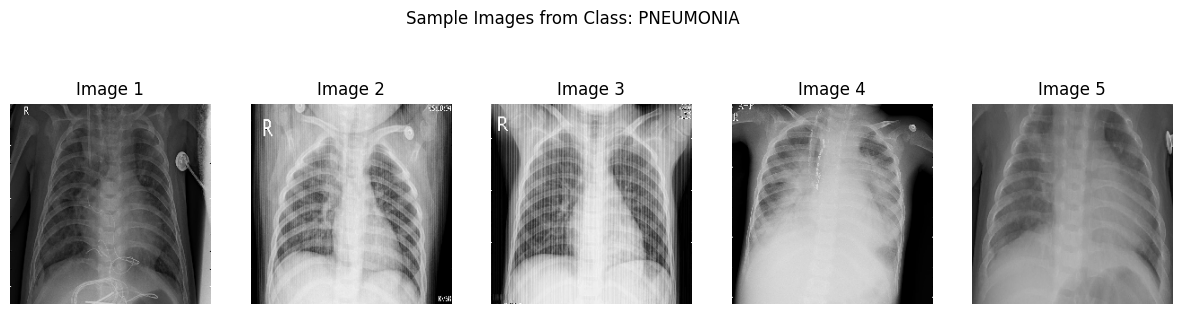

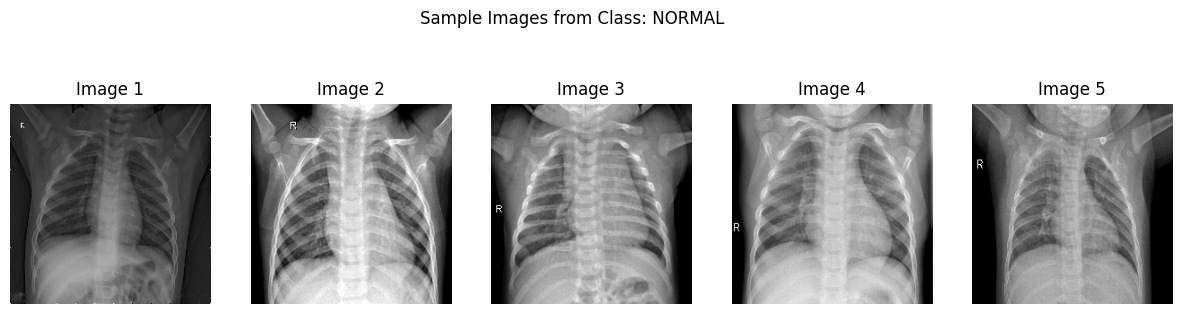

In [24]:
def plot_sample_images(directory, num_images=5):
    class_dirs = [os.path.join(directory, cls) for cls in os.listdir(directory)]
    
    # Plot sample images from each class directory
    for cls_dir in class_dirs:
        class_name = os.path.basename(cls_dir)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
        fig.suptitle(f'Sample Images from Class: {class_name}')
        
        # Load and plot sample images
        image_files = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)[:num_images]]
        for i, image_file in enumerate(image_files):
            image = load_img(image_file, target_size=(224, 224))  # Load and resize image
            axes[i].imshow(image)
            axes[i].set_title(f'Image {i+1}')
            axes[i].axis('off')
        plt.show()
plot_sample_images(train_dir)

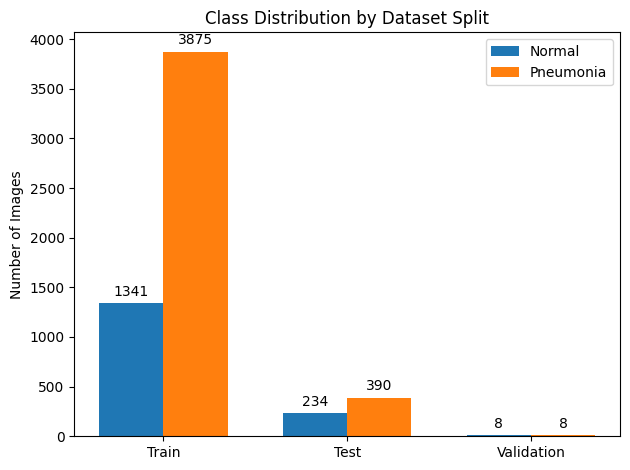

In [25]:
def count_images_in_classes(directory):
    num_normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    num_pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return num_normal, num_pneumonia

# Count images in train, test, and validation sets
train_normal, train_pneumonia = count_images_in_classes(train_dir)
test_normal, test_pneumonia = count_images_in_classes(test_dir)
validation_normal, validation_pneumonia = count_images_in_classes(validation_dir)

# Create bar plot for class distribution
labels = ['Train', 'Test', 'Validation']
normal_counts = [train_normal, test_normal, validation_normal]
pneumonia_counts = [train_pneumonia, test_pneumonia, validation_pneumonia]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normal_counts, width, label='Normal')
rects2 = ax.bar(x + width/2, pneumonia_counts, width, label='Pneumonia')

ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution by Dataset Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

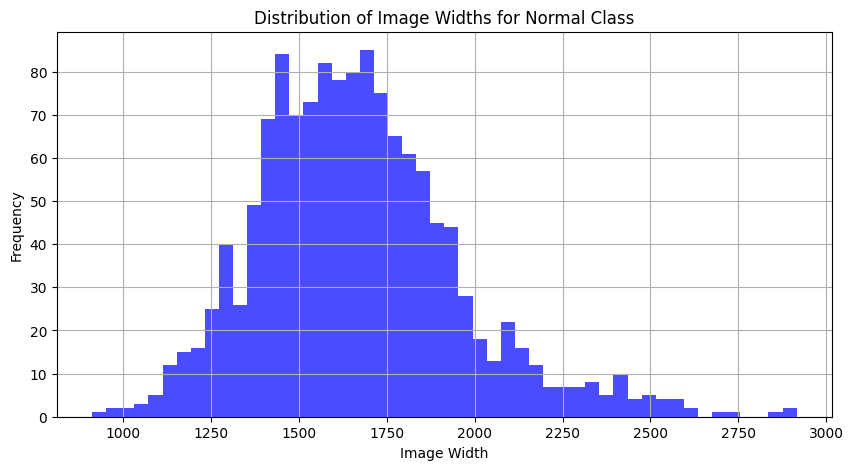

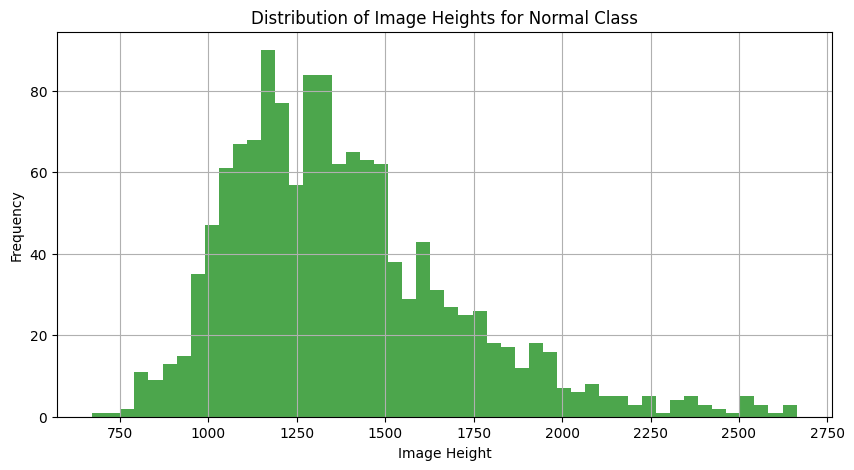

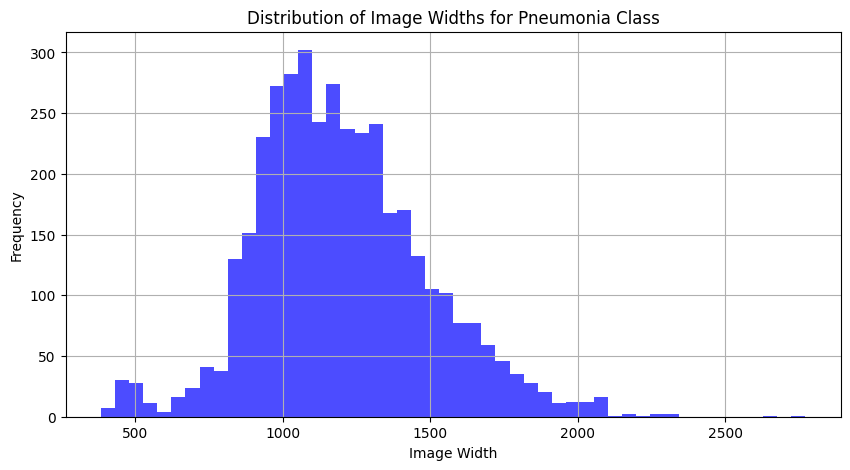

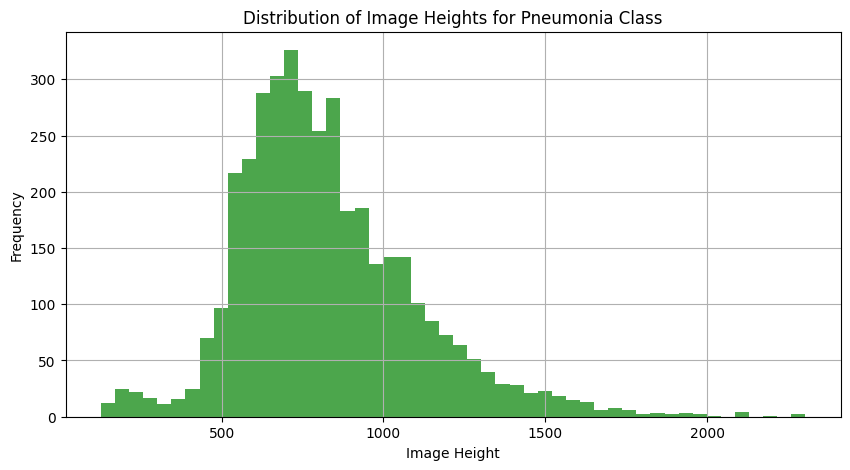

In [26]:
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

def get_image_sizes(directory):
    image_sizes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust file extensions as needed
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    height, width, _ = image.shape
                    image_sizes.append((width, height))
    return image_sizes

# Get image sizes for 'normal' class
normal_image_sizes = get_image_sizes(normal_dir)

# Extract width and height separately for 'normal' class
normal_widths, normal_heights = zip(*normal_image_sizes)

# Plot histogram for width of 'normal' class
plt.figure(figsize=(10, 5))
plt.hist(normal_widths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Image Width')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths for Normal Class')
plt.grid(True)
plt.show()

# Plot histogram for height of 'normal' class
plt.figure(figsize=(10, 5))
plt.hist(normal_heights, bins=50, color='green', alpha=0.7)
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights for Normal Class')
plt.grid(True)
plt.show()

# Get image sizes for 'pneumonia' class
pneumonia_image_sizes = get_image_sizes(pneumonia_dir)

# Extract width and height separately for 'pneumonia' class
pneumonia_widths, pneumonia_heights = zip(*pneumonia_image_sizes)

# Plot histogram for width of 'pneumonia' class
plt.figure(figsize=(10, 5))
plt.hist(pneumonia_widths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Image Width')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths for Pneumonia Class')
plt.grid(True)
plt.show()

# Plot histogram for height of 'pneumonia' class
plt.figure(figsize=(10, 5))
plt.hist(pneumonia_heights, bins=50, color='green', alpha=0.7)
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights for Pneumonia Class')
plt.grid(True)
plt.show()

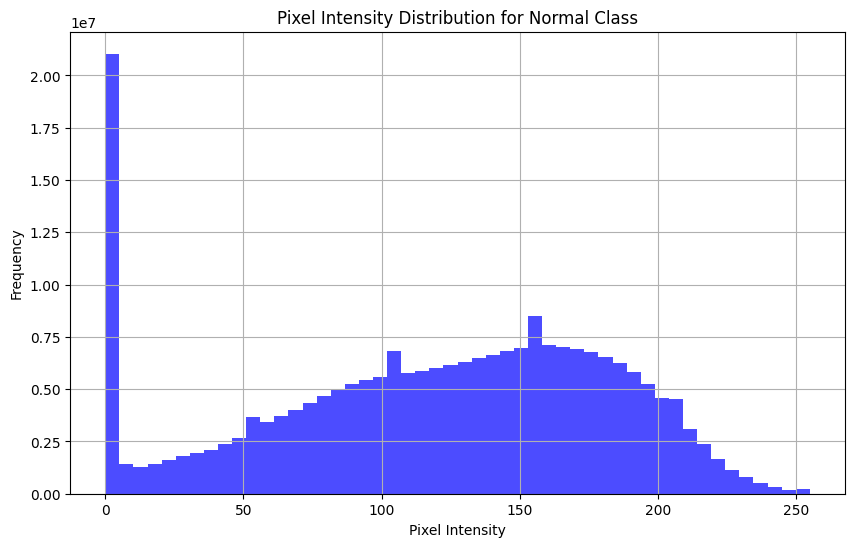

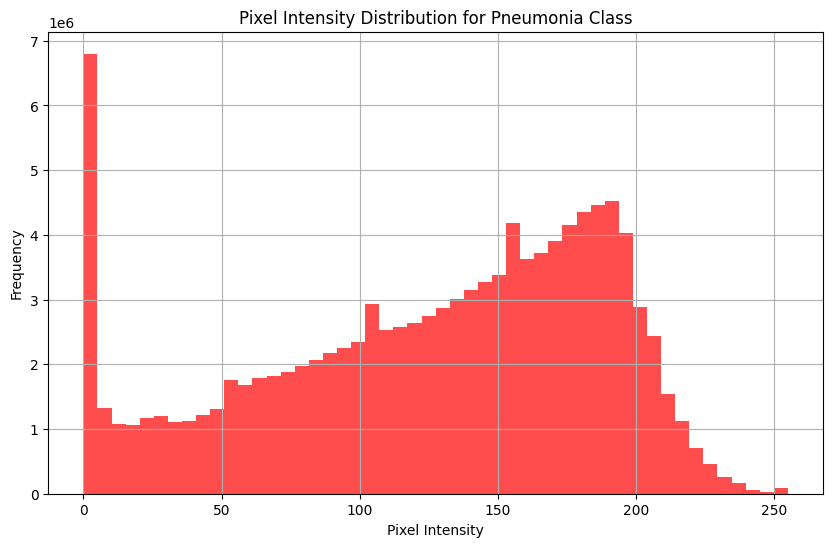

In [27]:
# Choose a sample of images for analysis
num_images_to_analyze = 100

# Function to load and analyze images from a directory
def analyze_images_from_directory(directory):
    pixel_intensity_values = []
    image_files = os.listdir(directory)
    for image_file in image_files[:num_images_to_analyze]:
        image_path = os.path.join(directory, image_file)
        try:
            image = cv2.imread(image_path)
            if image is not None:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                flattened_image = gray_image.flatten()
                pixel_intensity_values.extend(flattened_image)
            else:
                print(f"Failed to load image: {image_path}")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
    return np.array(pixel_intensity_values)

# Analyze images for 'normal' class
normal_pixel_intensity_values = analyze_images_from_directory(normal_dir)

# Analyze images for 'pneumonia' class
pneumonia_pixel_intensity_values = analyze_images_from_directory(pneumonia_dir)

# Plot histogram of pixel intensity values for 'normal' class
plt.figure(figsize=(10, 6))
plt.hist(normal_pixel_intensity_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution for Normal Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram of pixel intensity values for 'pneumonia' class
plt.figure(figsize=(10, 6))
plt.hist(pneumonia_pixel_intensity_values, bins=50, color='red', alpha=0.7)
plt.title('Pixel Intensity Distribution for Pneumonia Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

T-statistic: -901.2626288746617
P-value: 0.0


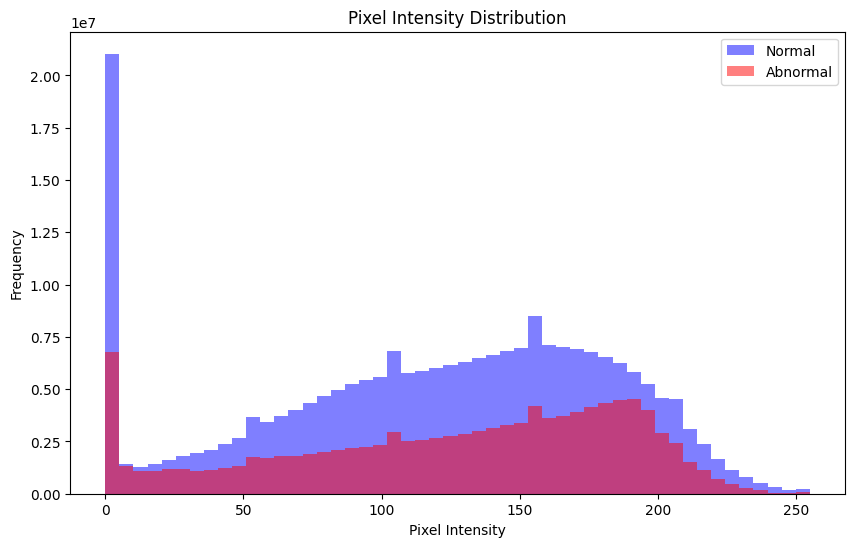

In [28]:
t_statistic, p_value = ttest_ind(normal_pixel_intensity_values.flatten(), pneumonia_pixel_intensity_values.flatten())

print("T-statistic:", t_statistic)
print("P-value:", p_value)

plt.figure(figsize=(10, 6))
plt.hist(normal_pixel_intensity_values.flatten(), bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(pneumonia_pixel_intensity_values.flatten(), bins=50, alpha=0.5, color='red', label='Abnormal')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.legend()
plt.show()


Found 5216 images belonging to 2 classes.


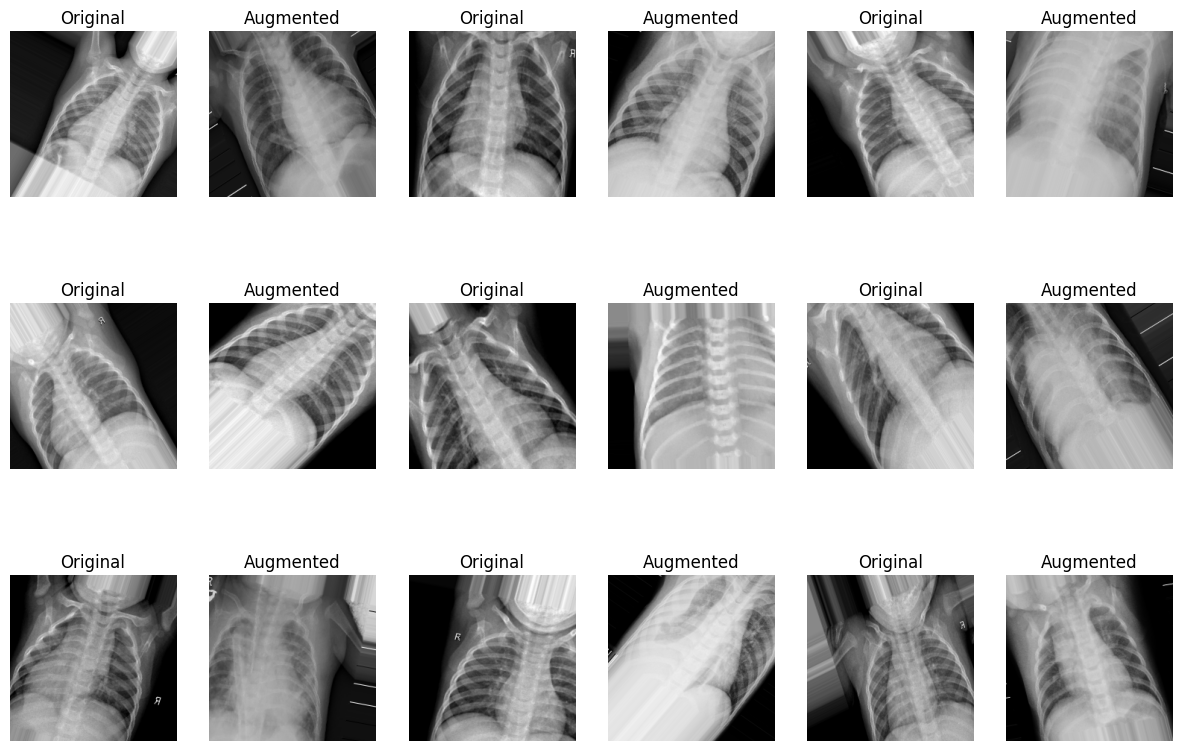

In [29]:
original_images, _ = next(train_augmentation_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=9,
    class_mode='binary',
    shuffle=False
))

augmented_images, _ = next(train_augmentation_generator)

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 6, 2*i + 1)
    plt.imshow(original_images[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(3, 6, 2*i + 2)
    plt.imshow(augmented_images[i])
    plt.title('Augmented')
    plt.axis('off')

plt.show()

In [30]:
base_model = VGG19(weights='/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 26,447,425 (100.89 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
    train_augmentation_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20


W0000 00:00:1711598329.601102     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 632ms/step - accuracy: 0.6877 - loss: 1.0850 - val_accuracy: 0.5000 - val_loss: 0.8974
Epoch 2/20


W0000 00:00:1711598432.504549     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 640ms/step - accuracy: 0.7470 - loss: 0.5712 - val_accuracy: 0.5000 - val_loss: 0.8547
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 630ms/step - accuracy: 0.7478 - loss: 0.5758 - val_accuracy: 0.5000 - val_loss: 0.6999
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 628ms/step - accuracy: 0.7176 - loss: 0.5970 - val_accuracy: 0.5000 - val_loss: 0.8686
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 632ms/step - accuracy: 0.7296 - loss: 0.5918 - val_accuracy: 0.5000 - val_loss: 0.8422
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 626ms/step - accuracy: 0.7426 - loss: 0.8116 - val_accuracy: 0.5000 - val_loss: 0.7390
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 638ms/step - accuracy: 0.7521 - loss: 0.5767 - val_accuracy: 0.5000 - val_loss: 0.8074
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 629ms/step - accuracy: 0.7488 - loss: 0.5652 - val_accuracy: 0.5000 - val_loss: 0.8194
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 636ms/step - accuracy: 0.7459 - loss: 0.56

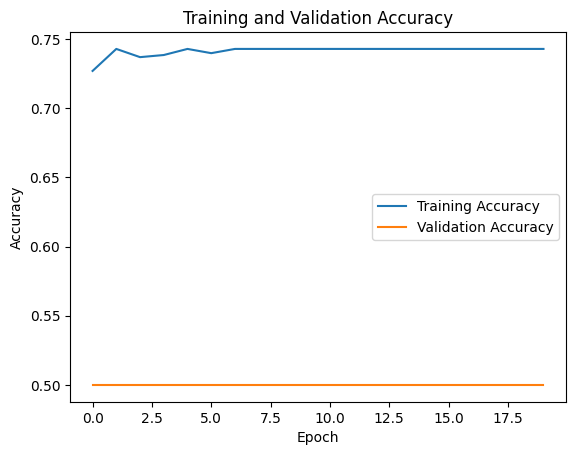

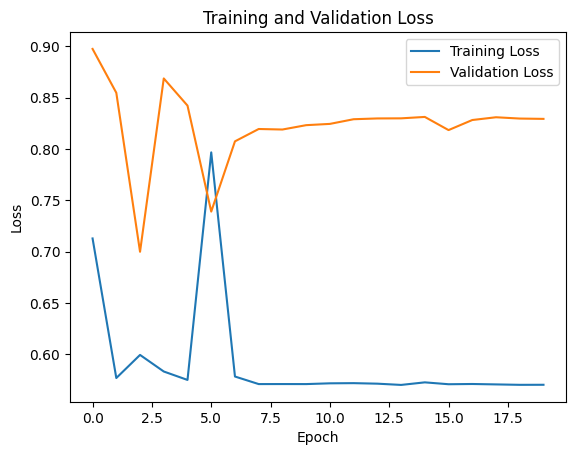

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [33]:
model.evaluate(test_generator)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 17s 897ms/step - accuracy: 0.4688 - loss: 0.8626

W0000 00:00:1711600518.900390     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.6125 - loss: 0.7090


[0.6941785216331482, 0.625]

In [47]:
# Transfer Learning VGG19
base_model = VGG19(weights='/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

In [48]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(
    train_augmentation_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:06 8s/step - accuracy: 0.5000 - loss: 0.7883

W0000 00:00:1711605393.729661     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 605ms/step - accuracy: 0.7465 - loss: 20.6302 - val_accuracy: 0.6875 - val_loss: 0.4989
Epoch 2/20


W0000 00:00:1711605491.916826     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 604ms/step - accuracy: 0.7979 - loss: 0.4564 - val_accuracy: 0.7500 - val_loss: 0.4683
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 602ms/step - accuracy: 0.8133 - loss: 0.4199 - val_accuracy: 0.6875 - val_loss: 0.5264
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 598ms/step - accuracy: 0.8095 - loss: 0.4086 - val_accuracy: 0.7500 - val_loss: 0.8533
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 598ms/step - accuracy: 0.8341 - loss: 0.4044 - val_accuracy: 0.8125 - val_loss: 0.4265
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 600ms/step - accuracy: 0.8409 - loss: 0.3747 - val_accuracy: 0.6250 - val_loss: 1.6651
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 600ms/step - accuracy: 0.8361 - loss: 0.3709 - val_accuracy: 0.6250 - val_loss: 0.8067
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 602ms/step - accuracy: 0.8460 - loss: 0.3517 - val_accuracy: 0.7500 - val_loss: 1.0302
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 604ms/step - accuracy: 0.8452 - loss: 0.37

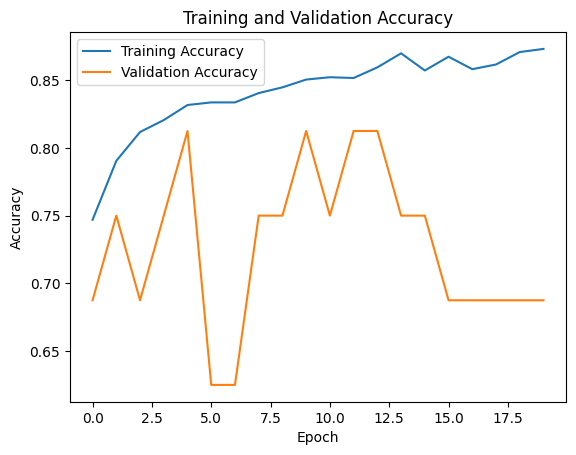

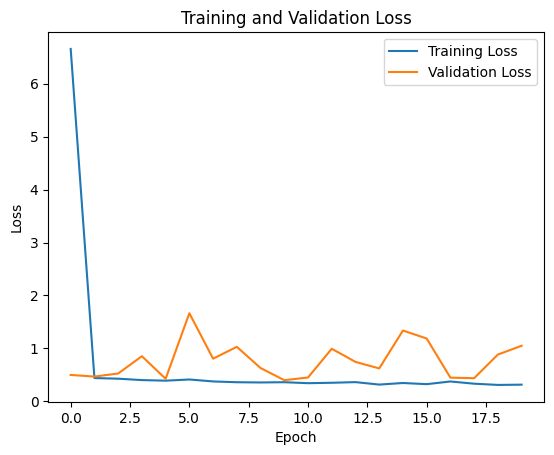

In [49]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [50]:
model1.evaluate(test_generator)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 15s 838ms/step - accuracy: 0.8125 - loss: 0.4806

W0000 00:00:1711607446.908785     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.8367 - loss: 0.5928


[0.5971744656562805, 0.8557692170143127]

In [42]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Set the initial learning rate and define the learning rate schedule
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Freeze the layers of the base model so they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Flatten the output of the base model and add fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model2 = Model(inputs=base_model.input, outputs=predictions)


In [44]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(
    train_augmentation_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 650ms/step - accuracy: 0.7442 - loss: 0.6007 - val_accuracy: 0.5000 - val_loss: 0.8283
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 606ms/step - accuracy: 0.7427 - loss: 0.5703 - val_accuracy: 0.5000 - val_loss: 0.8283
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 597ms/step - accuracy: 0.7421 - loss: 0.5711 - val_accuracy: 0.5000 - val_loss: 0.8300
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 596ms/step - accuracy: 0.7367 - loss: 0.5768 - val_accuracy: 0.5000 - val_loss: 0.8330
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 598ms/step - accuracy: 0.7439 - loss: 0.6720 - val_accuracy: 0.5000 - val_loss: 0.8290
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 601ms/step - accuracy: 0.7385 - loss: 0.5749 - val_accuracy: 0.5000 - val_loss: 0.8298
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 597ms/step - accuracy: 0.7401 - loss: 0.5732 - val_accuracy: 0.5000 - val_loss: 0.8306
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 598ms/step - accuracy: 0.7443 -

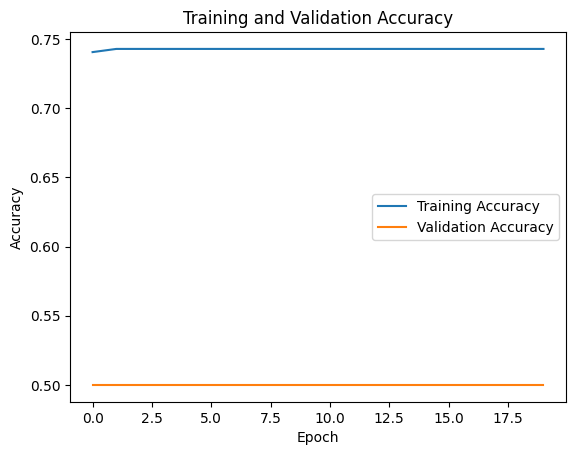

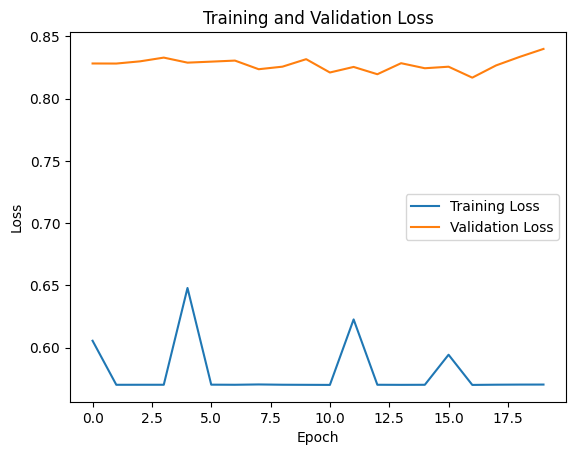

In [45]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [46]:
model2.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 278ms/step - accuracy: 0.6233 - loss: 0.7024


[0.6942394971847534, 0.625]

In [51]:
model.save('basemodel.h5')

In [52]:
model1.save('VGG19.h5')

In [53]:
model2.save('resnet50.h5')